# RL CartPole: Double DQN

In [10]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [143]:
import time

env = gym.make('CartPole-v1')
input_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation space:", input_shape, "n_actions:", n_actions)

# Set numpy seed
np.random.seed(42)

# Set TensorFlow seed
tf.keras.backend.clear_session()  # Clear previous TF graph
tf.random.set_seed(42)

# Set Python's built-in random seed
random.seed(42)
env.action_space.seed(42)  # Ensures deterministic action sampling
# Reset Gym environmen

Observation space: (4,) n_actions: 2


[42]

In [144]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Model:
model = Sequential([
    Dense(256, activation='relu',input_shape=input_shape),                #Elu activation function better than Relu for negative values (Relu can have dying neurons)
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(n_actions, activation='linear')
])

# Make the target model:
target_model = tf.keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

# Optimizer and loss
optimizer = Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.Huber()

inital_weights = model.get_weights()


@tf.function  # Compile the function for faster execution
def get_Q_values(state):
    return model(state, training=False)  # Avoids extra TF overhead


@tf.function
def get_target_Q_values(next_state):
    return target_model(next_state, training=False)

c:\Users\pierg\Desktop\VirtualEnvironments\Standard_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [145]:
from collections import deque
replay_buffer = deque(maxlen=1000000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# Defining epsilon_greedy_policy
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)  # Faster for exploration
    else:
        Q_values = get_Q_values(state[np.newaxis])  # Optimized function
        return np.argmax(Q_values.numpy()[0])                          #Q_values[0] to get the Q_values from the first dimension of the array (for teh first row or only row. Q_values [0] has 2 values, one for each possible action.)
        #return tf.argmax(Q_values, axis=1)[0]
        #return tf.argmax(Q_values, axis=1).numpy()[0] 

# Play one Step, using Epsilon Greedy Policy and store the state, action, reward, next_state and done in the replay buffer
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def play_n_steps(env, state, epsilon, n_steps):
    experiences = []
    total_reward = 0 
    for _ in range(n_steps):
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info = env.step(action)
        experiences.append((state, action, reward, next_state, done))
        total_reward += reward  
        state = next_state
        if done:
            break
    replay_buffer.extend(experiences)  
    return state, total_reward, done  


# Modified training:
# One training step
batch_size = 64
discount_factor = 0.99


@tf.function
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Step 1: Get Q-values for next states using the online model (model)
    next_Q_values_online = get_Q_values(next_states)  # Uses the online model to get Q-values
    
    # Step 2: Select the best actions based on the Q-values from the online model
    best_next_actions = tf.argmax(next_Q_values_online, axis=1)
    
    # Step 3: One-hot encode the best actions
    next_mask = tf.one_hot(best_next_actions, n_actions)
    
    # Step 4: Get Q-values for the next states using the target model (target_model)
    #next_Q_values_target = target_model(next_states)  # Use the target model for Q-value estimation
    next_Q_values_target = get_target_Q_values(next_states)  # Uses the target model to get Q-values
    
    # Step 5: Calculate the next best Q-values (for the selected actions) from the target model
    next_best_Q_values = tf.reduce_sum(next_Q_values_target * next_mask, axis=1)
    
    # Step 6: Calculate the target Q-values (Bellman equation)
    target_Q_values = rewards + (1 - dones) * discount_factor * next_best_Q_values
    
    # Step 7: One-hot encode the actions taken in the current states
    mask = tf.one_hot(actions, n_actions)
    
    # Step 8: Perform backpropagation using the current model to minimize the loss
    with tf.GradientTape() as tape:
        all_Q_values = model(states)  # Get Q-values from the online model
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)  # Select Q-values for the taken actions
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))  # Calculate loss
    
    # Step 9: Calculate gradients and apply them to update the model
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


Replay Buffer Size: 0
Episode: 0,Total Reward: 28.0, epsilon: 1.0, mean_reward: 28.0
Episode: 1,Total Reward: 10.0, epsilon: 0.9999, mean_reward: 10.0
Episode: 2,Total Reward: 20.0, epsilon: 0.9998, mean_reward: 20.0
Episode: 3,Total Reward: 10.0, epsilon: 0.9997, mean_reward: 10.0
Episode: 4,Total Reward: 27.0, epsilon: 0.9996, mean_reward: 27.0
Episode: 5,Total Reward: 34.0, epsilon: 0.9995, mean_reward: 34.0
Episode: 6,Total Reward: 18.0, epsilon: 0.9994, mean_reward: 18.0
Episode: 7,Total Reward: 21.0, epsilon: 0.9993, mean_reward: 21.0
Episode: 8,Total Reward: 23.0, epsilon: 0.9992, mean_reward: 23.0
Episode: 9,Total Reward: 19.0, epsilon: 0.9991, mean_reward: 19.0
Episode: 10,Total Reward: 31.0, epsilon: 0.999, mean_reward: 31.0
Episode: 11,Total Reward: 10.0, epsilon: 0.9989, mean_reward: 10.0
Episode: 12,Total Reward: 23.0, epsilon: 0.9988, mean_reward: 23.0
Episode: 13,Total Reward: 20.0, epsilon: 0.9987, mean_reward: 20.0
Episode: 14,Total Reward: 26.0, epsilon: 0.9986, mean_

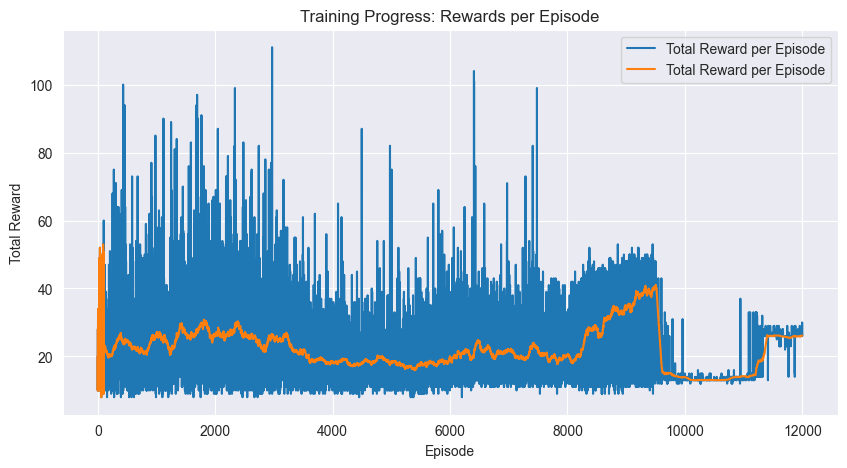

In [146]:
# Training Loop
# Set numpy seed
np.random.seed(42)

# Set TensorFlow seed
tf.keras.backend.clear_session()  # Clear previous TF graph
tf.random.set_seed(42)

# Set Python's built-in random seed
random.seed(42)

# Reset Gym environment
env = gym.make('CartPole-v1')
env.seed(42)
env.action_space.seed(42)  # Ensures action selection is deterministic
tf.keras.backend.clear_session()
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

episode_rewards = []
mean_episode_rewards = []
best_score = 0
total_rewards = 0
replay_buffer.clear()  # Clears all elements from the replay buffer
print(f"Replay Buffer Size: {len(replay_buffer)}")


model.set_weights(inital_weights)
target_model.set_weights(inital_weights)

for episode in range(12000):
    obs = env.reset(seed=42)
    total_reward = 0
    if episode > 0:
        epsilon = max(1 - (episode - 0)/ (10000-0), 0.01)
    else:
        epsilon = 1.0

    start_time_steps = time.time()
    '''
    for step in range(1000):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        total_reward += reward  # Accumulate reward
        if done:
            break
    '''
     # Use parallelized version of play_one_step
    obs, episode_reward, done = play_n_steps(env, obs, epsilon, n_steps=500)  
    end_time_steps = time.time()
    #print(f"\n Step Time: {end_time_steps - start_time_steps}")

    total_reward += episode_reward
    total_rewards += total_reward
    episode_rewards.append(total_reward)
    mean_episode_rewards.append(episode_rewards[-1] if episode < 100 else np.mean(episode_rewards[-100:]))

    if mean_episode_rewards[-1] > best_score:
        best_weights = model.get_weights()
        best_score = mean_episode_rewards[-1]

    if episode > batch_size:
        start_time_training_step = time.time()
        training_step(batch_size)
        end_time_training_step = time.time()
        #print(f"Training Step Time: {end_time_training_step - start_time_training_step}")
        #Soft Update:
        '''
        if episode % 100 == 0:
            tau = 0.01  # Soft update factor
            target_weights = target_model.get_weights()
            model_weights = model.get_weights()
            
            # Perform the soft update using tau
            new_weights = []
            for target_weight, model_weight in zip(target_weights, model_weights):
                new_weight = tau * model_weight + (1 - tau) * target_weight
                new_weights.append(new_weight)
            
            # Set the new weights to the target model
            target_model.set_weights(new_weights)
        '''
        if episode % 100 == 0:
            target_model.set_weights(model.get_weights())
            #print(f"Replay Buffer Size: {len(replay_buffer)}")
        
        
    print(f"Episode: {episode},Total Reward: {total_reward}, epsilon: {epsilon}, mean_reward: {mean_episode_rewards[-1]}")

model.set_weights(best_weights)
target_model.set_weights(best_weights)

# Use Seaborn to plot rewards per episode
sns.set_style("darkgrid")  # Set a nice style
plt.figure(figsize=(10, 5))  # Set figure size

sns.lineplot(x=range(len(episode_rewards)), y=episode_rewards, label="Total Reward per Episode")
sns.lineplot(x=range(len(mean_episode_rewards)), y=mean_episode_rewards, label="Total Reward per Episode")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Rewards per Episode")
plt.legend()
plt.show()

In [50]:
# For plotting the animated video
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


#env.seed(41)
state = env.reset()

frames = []

for i in range(30):
    total_reward = 0
    state = env.reset()
    for step in range(500):
        action = epsilon_greedy_policy(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            break
        img = env.render(mode="rgb_array")
        frames.append(img)
    print("Total Reward:", total_reward)
#plot_animation(frames)

Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
